# **TRATAR LOS DATOS**

## *SUBIR LAS IMAGENES ENCONTRADAS*

In [1]:
#Crear las carpetas para subir las imagenes
!mkdir autos
!mkdir bicicletas
!mkdir camionetas
!mkdir motos

In [ ]:
#Entrar en cada carpeta y descomprimir el archivo zip
%cd autos
!unzip /content/autos.zip
%cd ..

%cd bicicletas
!unzip /content/bicicletas.zip
%cd ..

%cd camionetas
!unzip /content/camionetas.zip
%cd ..

%cd motos
!unzip /content/motos.zip
%cd ..

In [3]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/autos | wc -l 
!ls /content/bicicletas | wc -l 
!ls /content/camionetas | wc -l 
!ls /content/motos | wc -l 

849
628
720
788


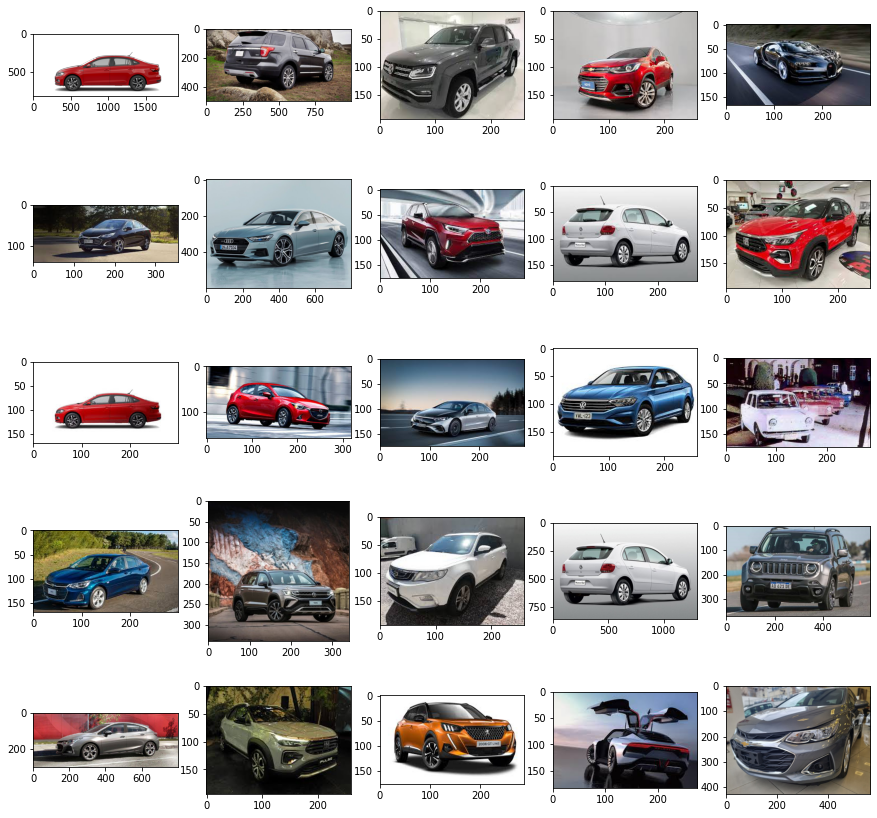

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Mostrar algunas imagenes con pyplot
plt.figure(figsize=(15,15))

carpeta = '/content/autos'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg, format="jpg")
  plt.imshow(imagen)

## *CREACIÓN DE LA CARPETA PARA EL DATASET*

In [5]:
#Crear carpetas para hacer el set de datos

!mkdir dataset
!mkdir dataset/autos
!mkdir dataset/bicicletas
!mkdir dataset/camionetas
!mkdir dataset/motos

In [6]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes
#maximo 245 (el num. menor de imagenes que subi)

import shutil

In [7]:
carpeta_fuente = '/content/autos'
carpeta_destino = '/content/dataset/autos'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 245:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [8]:
carpeta_fuente = '/content/bicicletas'
carpeta_destino = '/content/dataset/bicicletas'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 245:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [9]:
carpeta_fuente = '/content/camionetas'
carpeta_destino = '/content/dataset/camionetas'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 245:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [10]:
carpeta_fuente = '/content/motos'
carpeta_destino = '/content/dataset/motos'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 245:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [11]:
#Mostrar cuantas imagenes tengo de cada categoria en el dataset
!ls /content/dataset/autos | wc -l
!ls /content/dataset/bicicletas | wc -l
!ls /content/dataset/camionetas | wc -l
!ls /content/dataset/motos | wc -l

245
245
245
245


## *PROCESAMIENTO DE LOS DATOS Y CREACIÓN DEL DATASET*

Found 784 images belonging to 4 classes.
Found 194 images belonging to 4 classes.


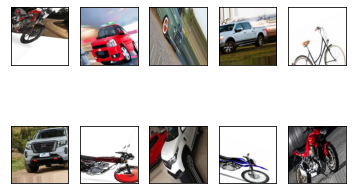

In [12]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()

# **CREAR EL MODELO**

## *IMPORTAR EL MODELO MOBILENETV2*

In [13]:
#Se importa y carga el modelo de google "mobilenetv2" para reconocimiento de imagenes
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [14]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

## *DEFINIR EL MODELO*

In [15]:
#Crea un modelo secuencial con el modelo mobilenetv2 y una nueva capa densa de 4 neuronas
#con función de activación 'relu'
modelo_rl = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(4, activation='relu')
])

In [16]:
modelo_rl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


# **ENTRENAR EL MODELO**

## *HISTORIAL DE ENTRENAMIENTO*

In [17]:
#Compilar
# adam = función optimizadora basada en AdaGrad y RMSprop
# categorical_crossentropy = función que calcula la pérdida de entropía cruzada entre las etiquetas y las predicciones.
# accuracy = calcula que tan seguido las predicciones son iguales a las etiquetas
modelo_rl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
#Entrenar el modelo
EPOCAS = 25

from tensorflow.keras.callbacks import TensorBoard
tensorboardDenso = TensorBoard(log_dir='logs/denso')
historial = modelo_rl.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas,
    callbacks=[tensorboardDenso]
)

Epoch 1/25
20/25 [=======================>......] - ETA: 5s - loss: 1.4711 - accuracy: 0.4631

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/25 [==============================] - 50s 2s/step - loss: 1.3149 - accuracy: 0.5204 - val_loss: 0.7196 - val_accuracy: 0.7526
Epoch 2/25
25/25 [==============================] - 39s 2s/step - loss: nan - accuracy: 0.5995 - val_loss: nan - val_accuracy: 0.2526
Epoch 3/25
25/25 [==============================] - 39s 2s/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2526
Epoch 4/25
25/25 [==============================] - 50s 2s/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2526
Epoch 5/25
25/25 [==============================] - 39s 2s/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2526
Epoch 6/25
25/25 [==============================] - 39s 2s/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2526
Epoch 7/25
25/25 [==============================] - 51s 2s/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2526
Epoch 8/25
25/25 [==============================] - 39s 2s/step - l

## *GRÁFICOS DE COMPARACIÓN*

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(25)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

# **MATRIZ DE CONFUSIÓN**

In [20]:
from cv2 import data
LABELS=['auto', 'bicicleta', 'camioneta', 'moto']
test_vehiculo = []
test_labels = []

for imagen, etiqueta in data_gen_pruebas:
  for i in range(len(data_gen_pruebas)):
    value = 0
    test_vehiculo.append(imagen[i])
    
    for valor in etiqueta[i]:
      if valor == 1:
        value = np.where(etiqueta[i] == valor)
        test_labels.append(value[0][0])
  break

len(data_gen_pruebas)
len(test_vehiculo)
len(test_labels)

7

In [22]:
y_pred = []

for i in range(len(test_vehiculo)):
  resultado = modelo_rl.predict(test_vehiculo[i].reshape(-1, 224, 224, 3))
  y_pred.append(np.argmax(resultado[0], axis=-1))

len(y_pred)

7

In [23]:
y_true = test_labels

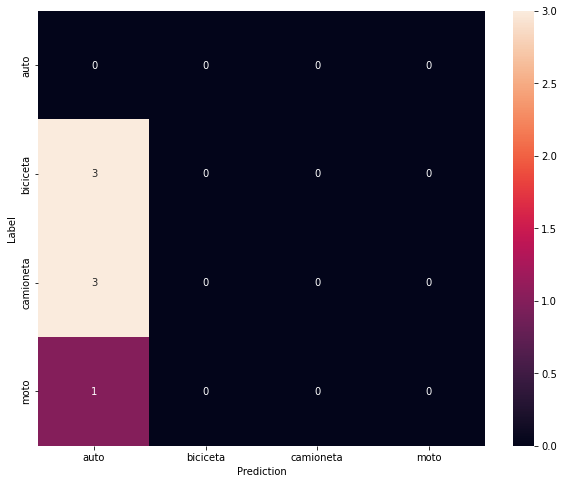

In [24]:
import seaborn as sns
commands = ['auto', 'biciceta', 'camioneta', 'moto']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# **MATRIZ DE CONFUSIÓN**

In [ ]:
#Categorizar una imagen de internet
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo_rl.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

In [ ]:
#0 = auto, 1 = bicicleta, 2 = camioneta, 3 = moto
url = 'https://s1.eestatic.com/2021/08/23/como/606450001_201130541_1706x960.jpg' #bici
prediccion = categorizar(url)
print(prediccion)

# **EXPORTACIÓN DEL MODELO**

In [ ]:
!pip install tensorflowjs

In [ ]:
primer_modelo.save('estacionamiento_tercermodelo')

In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve estacionamiento_tercermodelo carpeta_salida